In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from typing import List
import matplotlib.pyplot as plt

from models.aae import Encoder, Decoder, Discriminator, train, reconstruction_anomaly
from tools.viz import plot_anomaly_scores, plot_train_hist

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "joint"
        self.scaler = MinMaxScaler((-1, 1))
        self.l_dim = 128
        # self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 500
        self.sample_interval = 100
        self.train_plots = True
        self.iters = 2
        self.anomaly_threshold = 0.05
        
        self.model_out = Path('./runs/iterative/' + time_id + f"_ldim{self.l_dim}")

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Datasets

In [2]:
def setup_train_dataset(anomalies : List[str], iter):
    dataset = MULTI_VP_Dataset(
        path=opts.data_path,
        method=opts.method,
        remove_extreme=True, # TODO try only removing in the first iteration
        is_train=True,
        scaler=opts.scaler, 
    )
    dataset.remove_files(anomalies)
    dataset.plot(f"Data Iter {iter}")
    plt.savefig(opts.model_out / f"img/data_iter{iter}.png")
    plt.close()
    return DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

def setup_test_dataset(train_dataset : MULTI_VP_Dataset):
    dataset = MULTI_VP_Dataset(
        path=opts.data_path,
        method=opts.method,
        remove_extreme=False,
        is_train=False,
        scaler=train_dataset.scaler
    )
    return DataLoader(dataset, batch_size=opts.batch_size, shuffle=False, num_workers=opts.nworkers, drop_last=False)

# Training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
anomalies = []

Iteration  0
Removed 705 extreme values
Inputs shape: (11066, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.         -1.
  -1.        ]]
Bad files:  [] 0
Removed 0 files
Unscaled inputs shape: (11066, 1280)
Starting Training Loop...
Iteration  0 Anomaly DetectionG: 0.0007	D(x): 0.4748	D(G(z)): 0.7597
Inputs shape: (11771, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.        

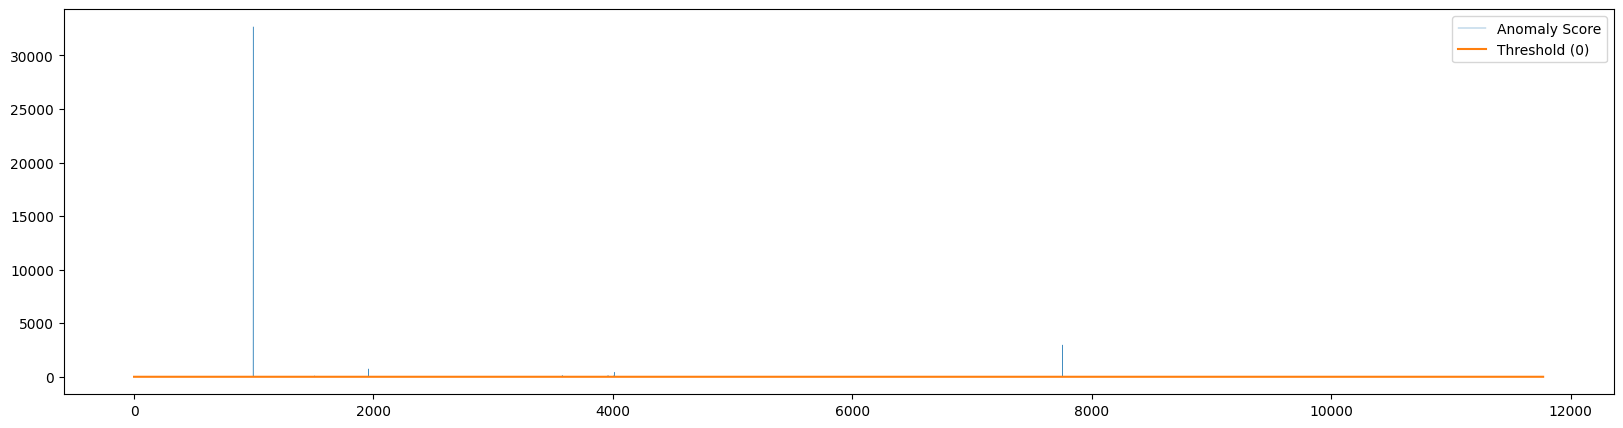

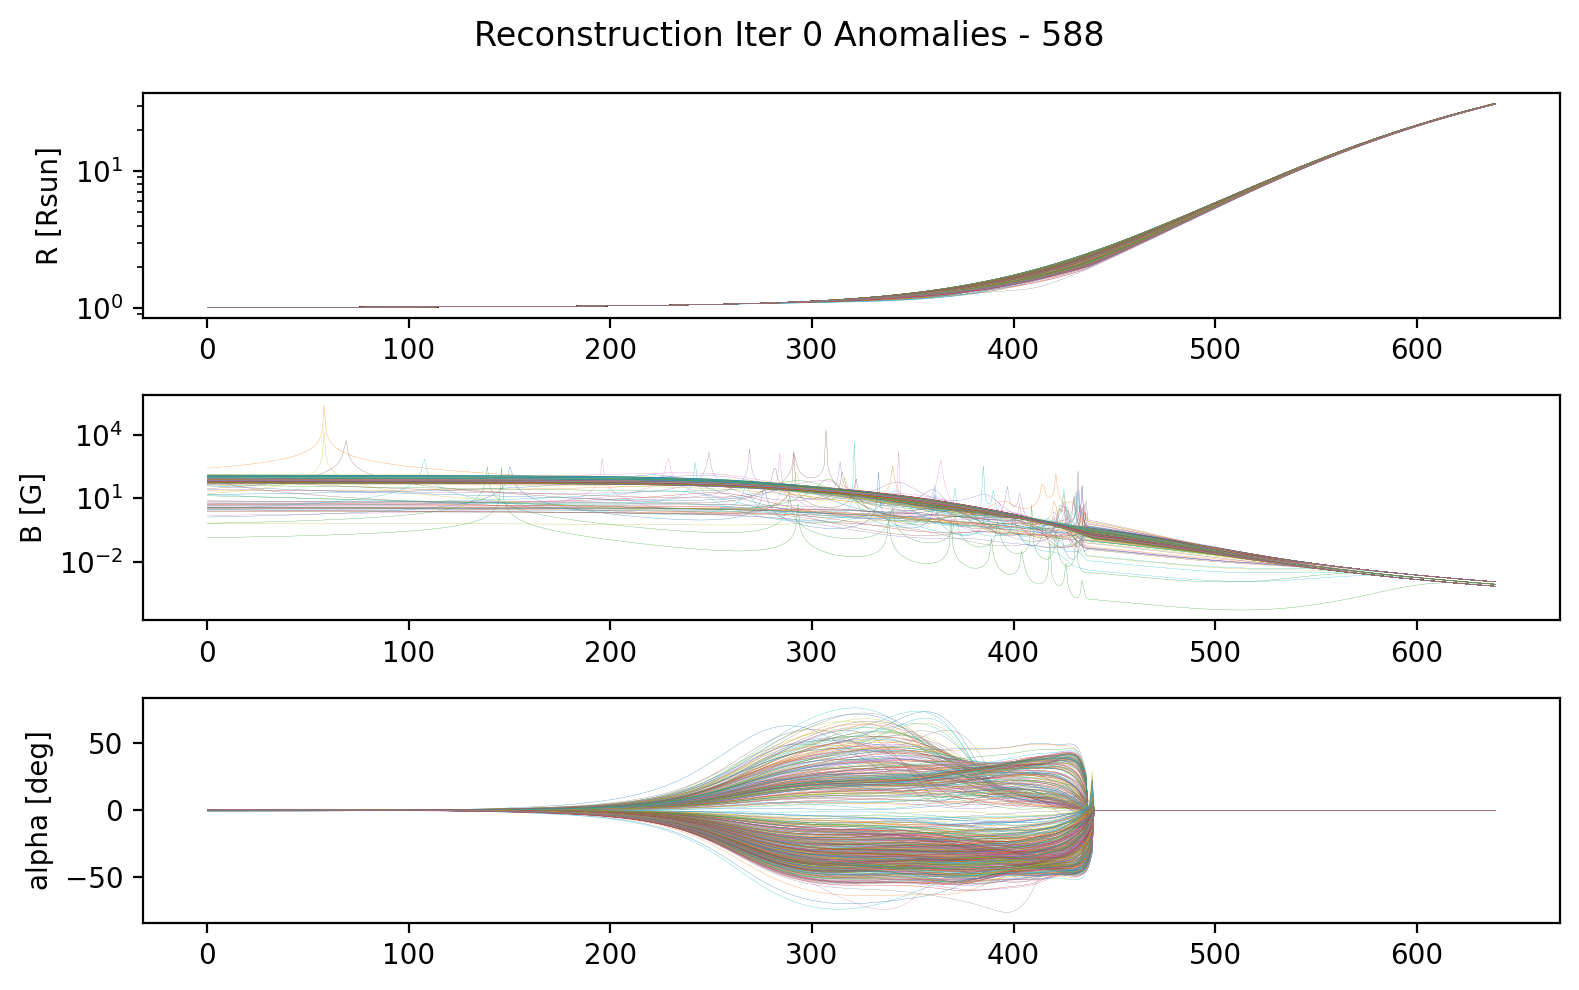

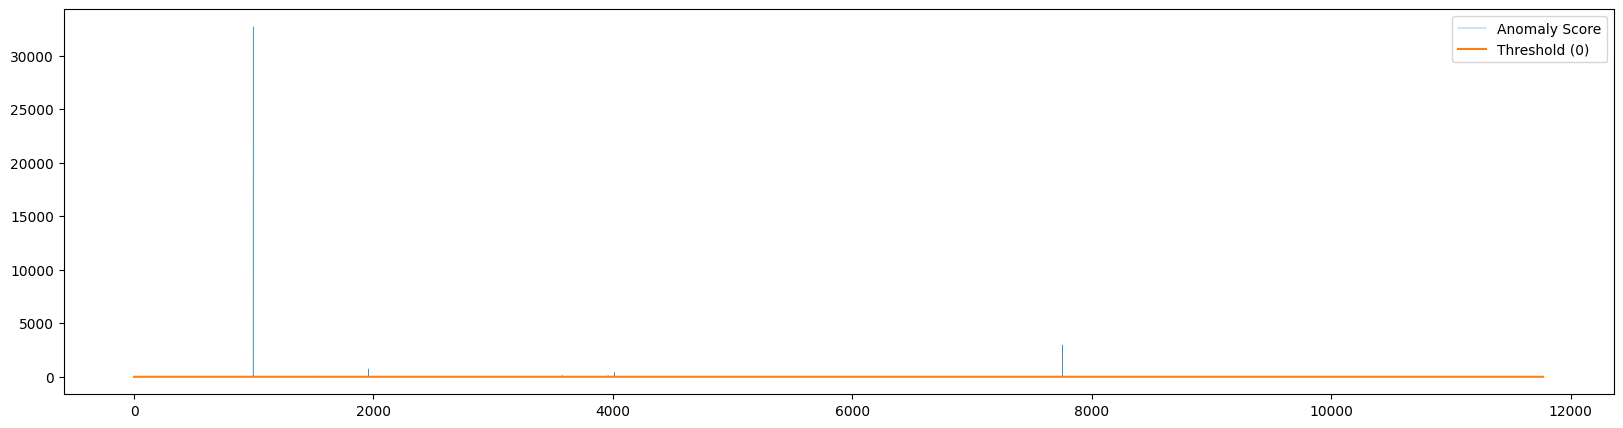

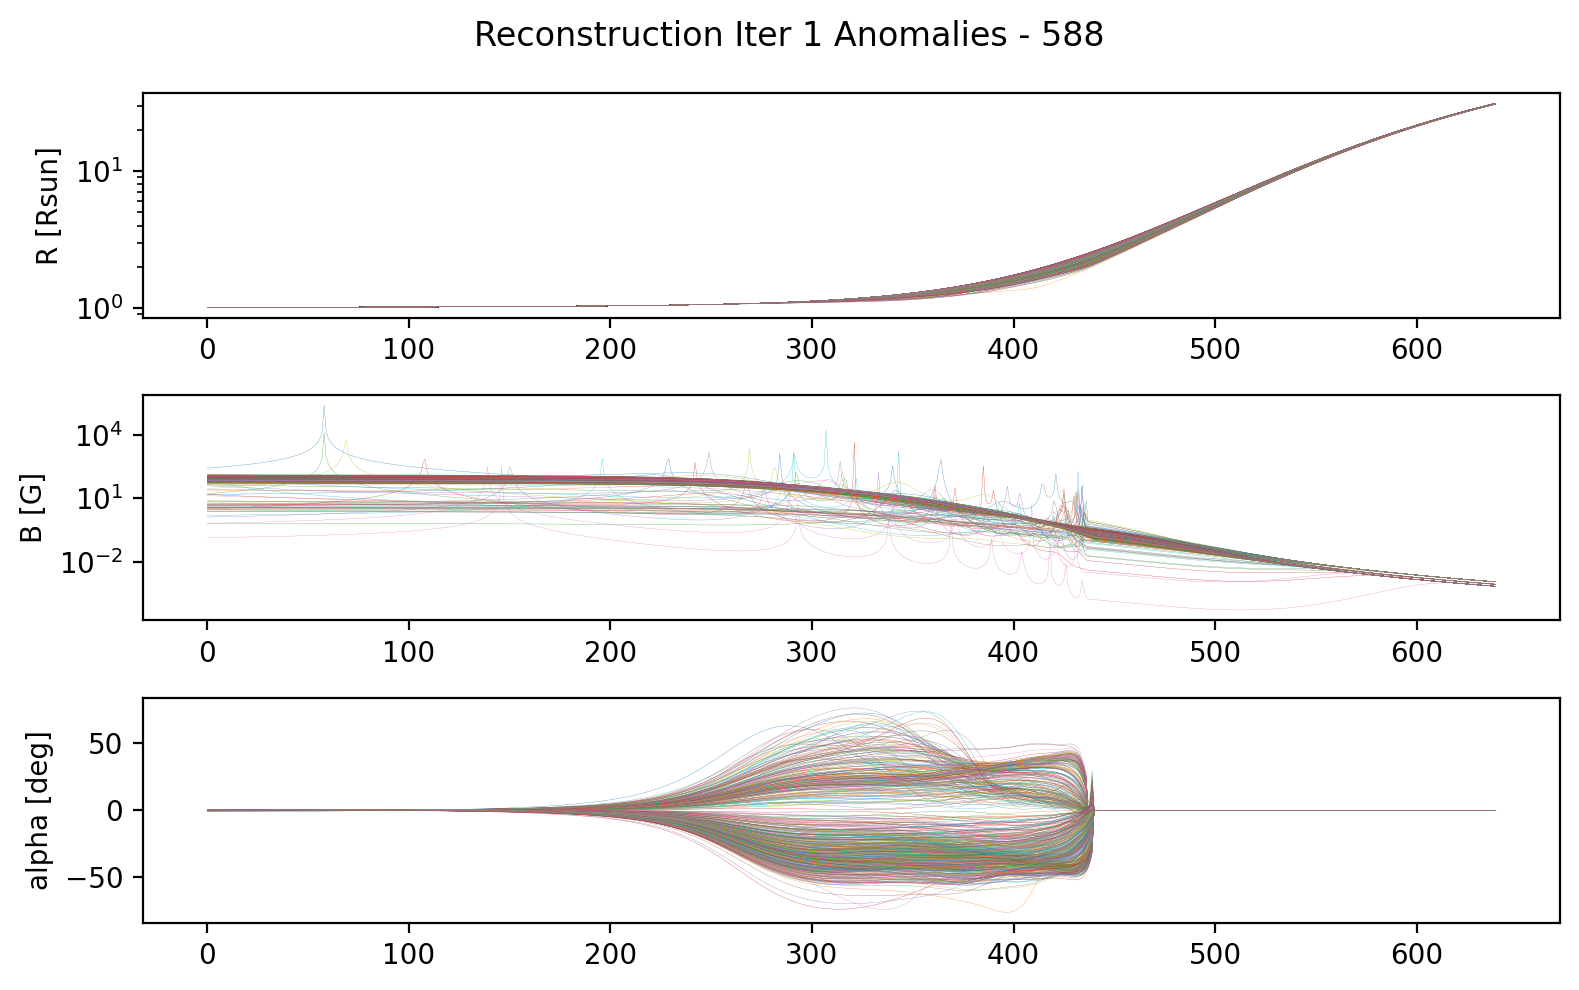

In [8]:
for i in range(opts.iters):
    print("Iteration ", i)
    train_dataloader = setup_train_dataset(anomalies, i)
    
    netEnc = Encoder(input_size=1280, l_dim=opts.l_dim, device=device).to(device)
    netDec = Decoder(output_size=1280,l_dim=opts.l_dim).to(device)
    netD = Discriminator(l_dim=opts.l_dim).to(device)

    netEnc.train(), netDec.train(), netD.train()
    G_losses, D_losses = train(netEnc, netDec, netD, train_dataloader, opts, device, model_id=f"iter{i}")
    
    # Anomaly Detection
    print("Iteration ", i, "Anomaly Detection")
    eval_dataloader = setup_test_dataset(train_dataloader.dataset)
    # TODO: load "best"
    netEnc.train(False), netDec.train(False), netD.train(False)
    anomaly_scores = reconstruction_anomaly(netDec, netEnc, eval_dataloader, device)
    thresh , _ = plot_anomaly_scores(anomaly_scores, opts.anomaly_threshold, opts.data_path, opts.model_out /  f"img/iter{i}_reconstr_scores",
                        scale="linear", method=f"Reconstruction Iter {i}")
    anomalies.extend([score[0] for score in anomaly_scores if score[1] > thresh])
    

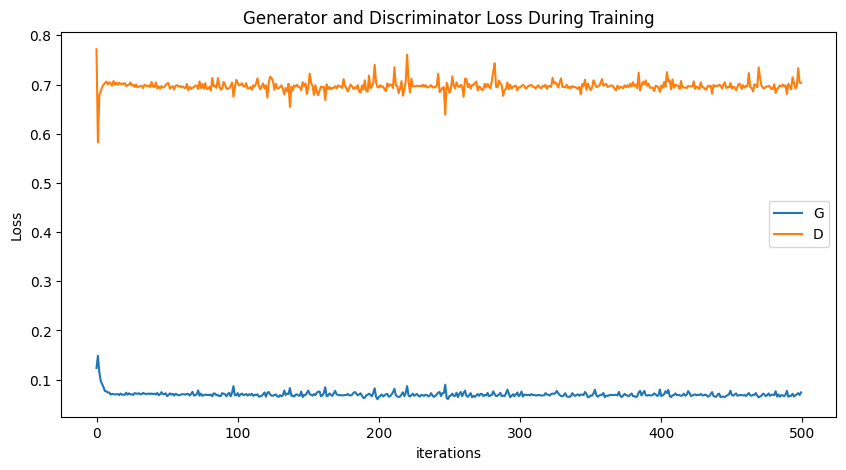

In [ ]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [ ]:

netEnc.train(False)
netDec.train(False)
netD.train(False)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/aae/0315-1819_ldim128")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netEnc.load_state_dict(torch.load(opts_eval.models_dir / 'Enc.pth'))
netDec.load_state_dict(torch.load(opts_eval.models_dir / 'Dec.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D.pth'))

<All keys matched successfully>

In [ ]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.         -1.
  -1.        ]]


## Reconstruction Error

In [ ]:
scores = []
loss_fn = nn.L1Loss(reduction="none")
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    errG = loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        scores.append((filename, error))

Anomaly Threshold:  0.020113326609134674
Found 1216 anomalies


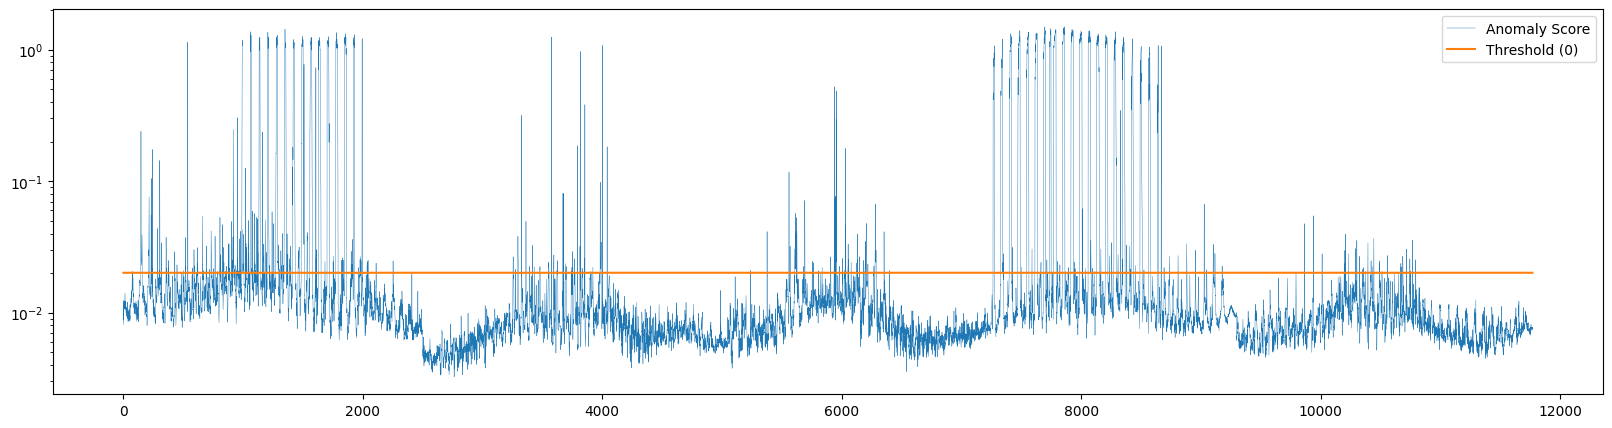

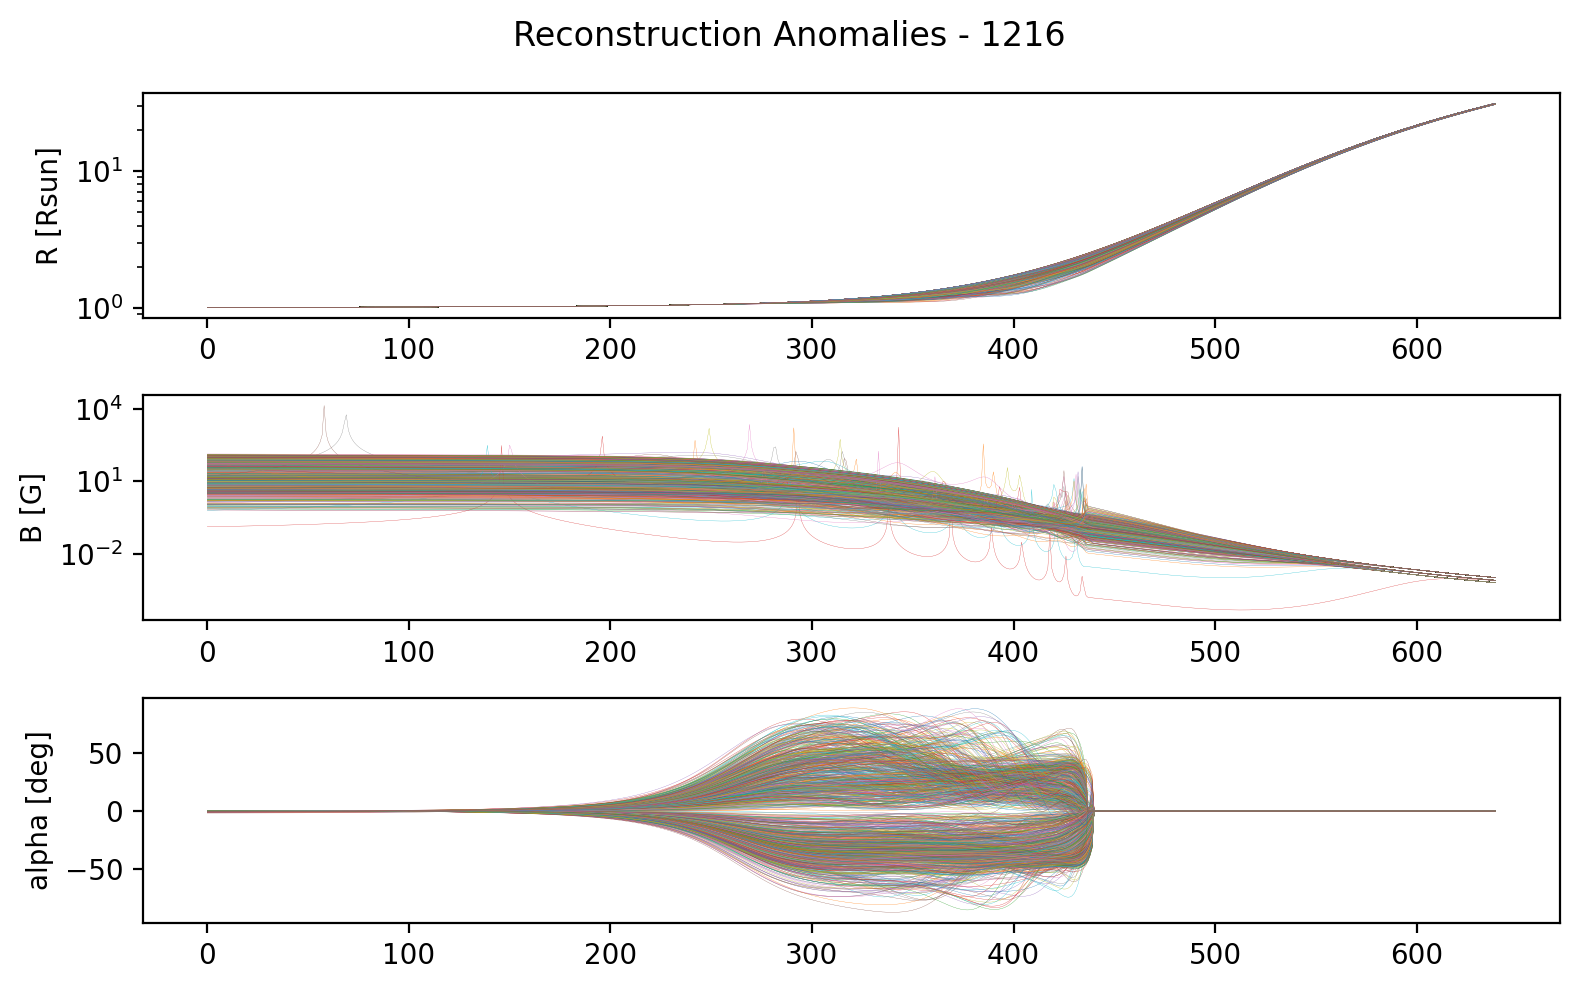

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/reconstr_scores",
                        scale="log", method="Reconstruction")

## Reconstruction + Discriminator

In [ ]:
scores_discr = []
loss_fn = nn.L1Loss(reduction="none")
criterion = nn.BCELoss()

# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    bsize = x.shape[0]
    real_labels = torch.full((bsize, 1), 1, dtype=torch.float, device=device)
    
    errG = 0.1 * criterion(netD(enc_x), real_labels) + 0.9 * loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().numpy()
    # errG = loss_fn(dec_x, x).mean(-1)
    # errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        # print(sample, filename)
        scores_discr.append((filename, error))

../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [99,0,0] Assertion `input_val >= zero && input_val <= one` failed.


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasLtMatmul( ltHandle, computeDesc.descriptor(), &alpha_val, mat1_ptr, Adesc.descriptor(), mat2_ptr, Bdesc.descriptor(), &beta_val, result_ptr, Cdesc.descriptor(), result_ptr, Cdesc.descriptor(), &heuristicResult.algo, workspace.data_ptr(), workspaceSize, at::cuda::getCurrentCUDAStream())`

Anomaly Threshold:  0.07857996
Found 1177 anomalies


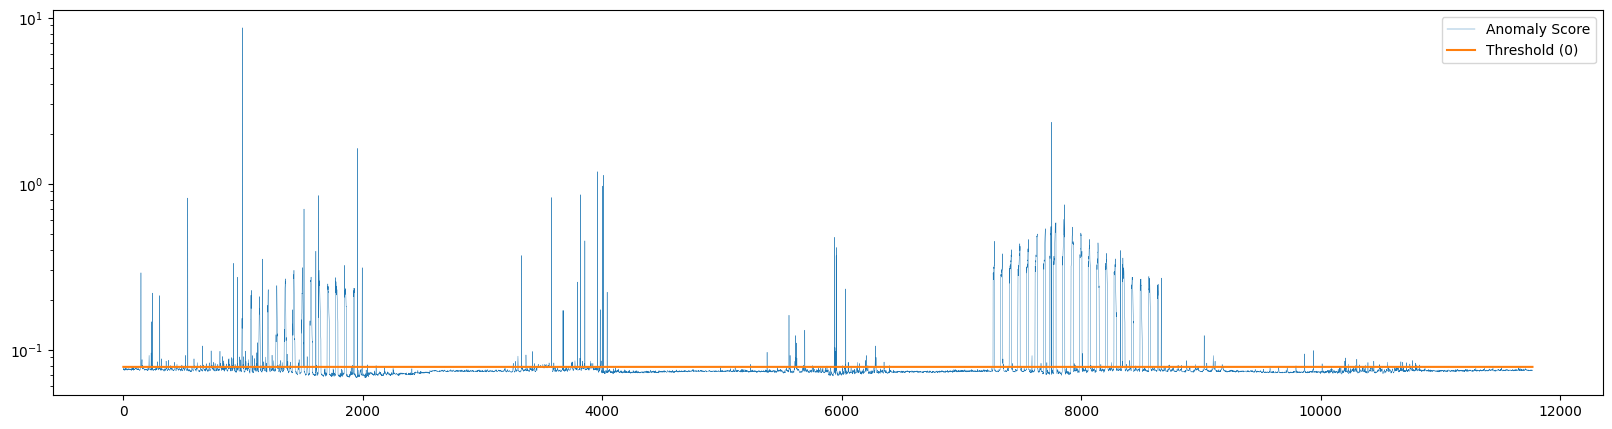

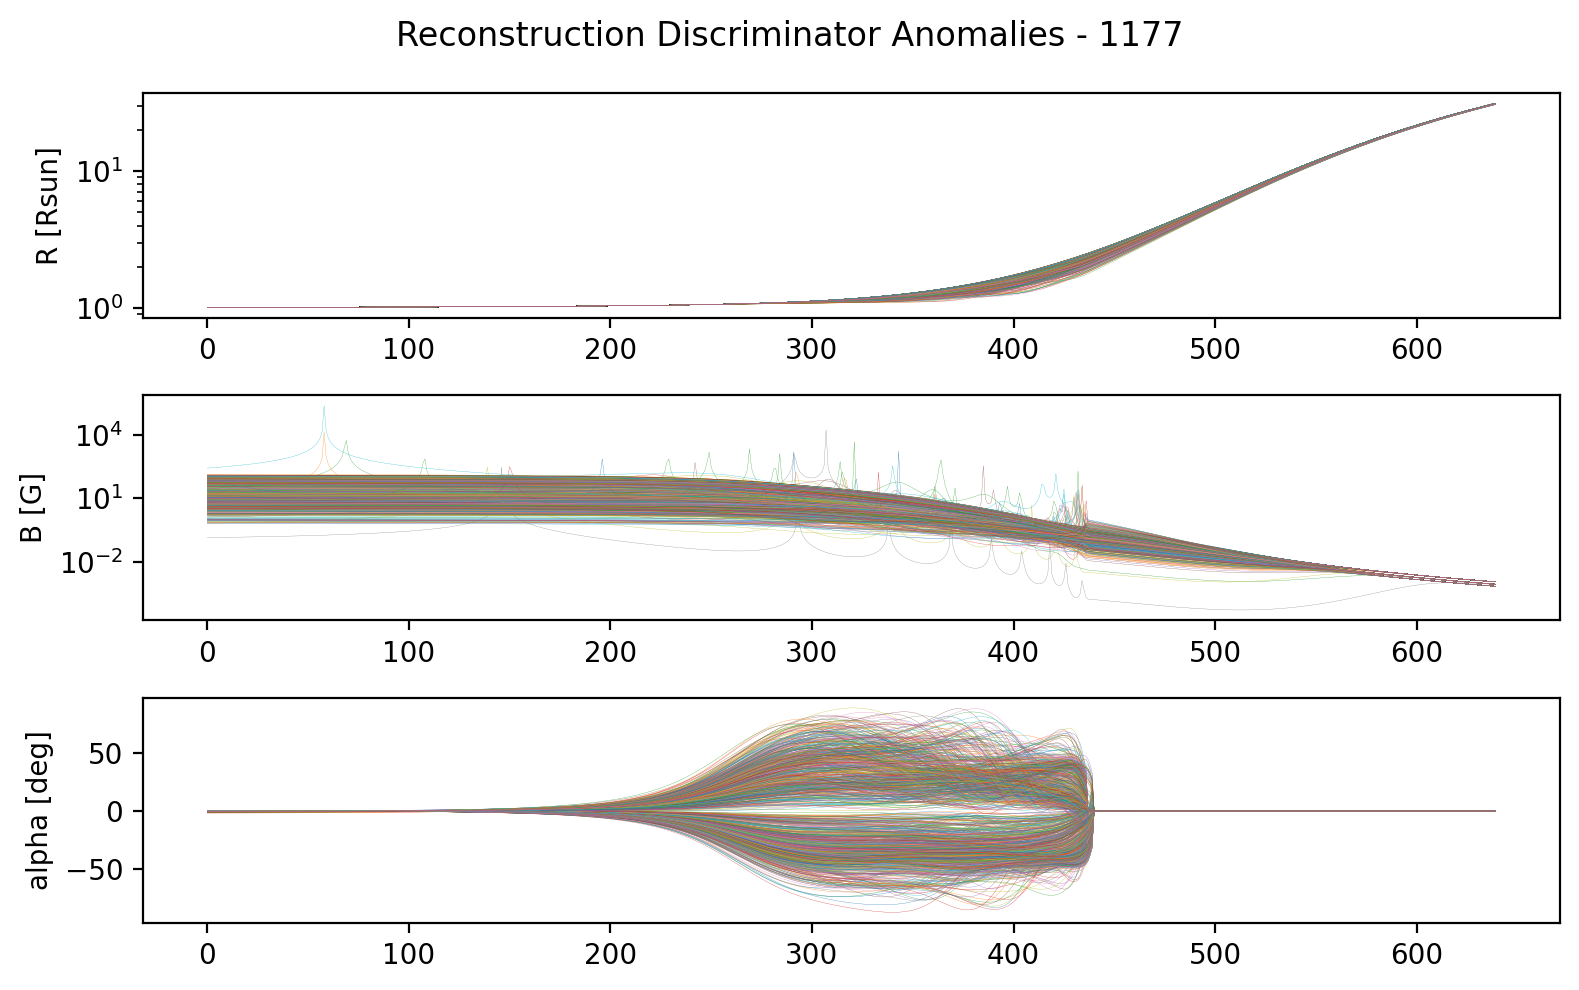

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_discr_scores", 
                        scale="log", method="Reconstruction Discriminator")